In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import json
import os


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import recall_score

import seaborn as sns

from sklearn.model_selection import learning_curve, validation_curve


In [2]:
def read_maneuver_map(path, debug=False):
    # Ensure the path is a string
    if not isinstance(path, str):
        raise ValueError("Path must be a string")
    
    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f"File {path} does not exist")
    
    # Read the JSON file and return as a dictionary
    with open(path, 'r') as json_file:
        data = json.load(json_file)
    
    if debug:
        print(f"Read JSON from {path}: {data}")
    
    return data

# Define high level features that are calculated for each low level feature
# TODO: add more high lvl features
# TODO: attention these do not make sense for categorical data types
HIGH_LVL_FEATURE_FUNCTION_MAP = {
    'Mean' : np.mean, 
    'StdDeviation' : np.std, 
    'Min' : np.min, 
    'Max' : np.max, 
    'Median' : np.median,
}

# Attention: do only supply numerical values
# Extract high level features for one block (for each low level feature, extract all high level features specified above)
# block_data -> dataframe of values to be summarized in high level features
# high_level_feature_function_map -> each entry in this map will be applied like this:
# create a new col using the key and the function value to the original colums
# this is repeated for each column of the original df -> col * key count (applies func to entire col)
def extract_high_lvl_features(block_data, high_level_feature_function_map=HIGH_LVL_FEATURE_FUNCTION_MAP):
    # Create an empty list to store results
    processed_data = []

    for low_lvl_feature in block_data.columns:
        # For each low-level feature, apply each high-level function
        for prefix, func in high_level_feature_function_map.items():
            # Apply the function to the column and store the result
            processed_data.append(func(block_data[low_lvl_feature]))

    # Convert the processed data into a DataFrame
    processed_block_data = pd.DataFrame(processed_data).T

    # Now, update the columns to have meaningful names like 'Mean_feature1', 'StdDeviation_feature1', etc.
    processed_block_data.columns = [f'{prefix}_{low_lvl_feature}' 
                                    for low_lvl_feature in block_data.columns 
                                    for prefix in high_level_feature_function_map.keys()]

    return processed_block_data

# expects a flight df and transforms with high level features
# block_size is self explanatory
# block_count_ratio is ratio e.g 0.5 of generated blocks in ratio with df length
# e.g with block_size 500 and ratio 0.5 the function generates the amount of blocks that with the block_size covers the block_count_ratio
def get_block_features(data, block_size, block_count_ratio):

    processed_df = pd.DataFrame()
    # represents rounded down amount of blocks to get ratio
    block_count = int(len(data) * block_count_ratio / block_size)
    if block_count < 1:
        raise Exception("the block_size is too big and produces block_count < 1")
    
    # create block_count blocks
    for i in range(block_count):
        # Generate random start index
        start_index = np.random.randint(0, len(data) - block_size + 1)    

        # USE COPY HERE TO PREVENT MULTIPLE processings of same rows
        # Select rows from start index to start index + block size
        block_data_copy_df = data.iloc[start_index:start_index + block_size].copy()   
        single_processed_block_df = extract_high_lvl_features(block_data_copy_df.select_dtypes(include='number'))

        # Find most common category for categorical types in block
        for categorical_column in block_data_copy_df.select_dtypes(include='category').columns:
            most_common_category = block_data_copy_df[categorical_column].value_counts().idxmax()
            single_processed_block_df[categorical_column] = pd.Categorical([most_common_category], categories=block_data_copy_df[categorical_column].cat.categories)

        # add the block to the result
        processed_df = pd.concat([processed_df, single_processed_block_df], ignore_index=True)
    return processed_df.convert_dtypes()

# loads all pickle files from parsed_data into single df
# features expects python list of feature names to load
# block_size is self explanatory
# block_count_ratio is ratio e.g 0.5 of generated blocks in ratio with df length
# e.g with block_size 500 and ratio 0.5 the function generates the amount of blocks that with the block_size covers the block_count_ratio
#
# further info blocks are create on the basis of specific flies not over the df which contains all data
def training_data(features, block_size, block_count_ratio): 
    df = pd.DataFrame()
    pkl_files = glob.glob(os.path.join('parsed_data', '*.pkl'))

    #print(pkl_files)
    # do only concat cols which are in each pickle
    for i, pkl_file in enumerate(pkl_files):
        # load additional data from file
        additional_df = pd.read_pickle(pkl_file)
        # select wanted features
        additional_df = additional_df[features]
        #######################################################################
        maneuver_df = additional_df['maneuver']
        additional_df = additional_df.select_dtypes(include='number')  #WE DROP ALL THE CATEGORIES since e.g list is hardly usable without further work
        additional_df['maneuver'] = maneuver_df
        maneuver_df = None
        #######################################################################

        # NOW SPLIT INTO BLOCKS
        additional_df = get_block_features(additional_df,block_size,block_count_ratio)

        for col in additional_df.select_dtypes(include='category').columns:
            # this should be in the df except first iteration
            if col in df.columns:
                # create categorical union
                uc = pd.api.types.union_categoricals([df[col], additional_df[col]])
                # give them union categories to both df
                df[col] = pd.Categorical(df[col], categories=uc.categories) 
                additional_df[col] = pd.Categorical(additional_df[col], categories=uc.categories)

        # finally we may concat
        df = pd.concat([df, additional_df], ignore_index=True)

    return df

# loads all pickle files from parsed_data into single df
# features expects python list of feature names to load
# block_size is self explanatory
# block_count_ratio is ratio e.g 0.5 of generated blocks in ratio with df length
# e.g with block_size 500 and ratio 0.5 the function generates the amount of blocks that with the block_size covers the block_count_ratio
#
# further info blocks are create on the basis of specific flies not over the df which contains all data
def test_data(features, block_size, block_count_ratio): 
    df = pd.DataFrame()
    pkl_files = glob.glob(os.path.join('parsed_test_data', '*.pkl'))

    print(pkl_files)
    # do only concat cols which are in each pickle
    for i, pkl_file in enumerate(pkl_files):
        # load additional data from file
        additional_df = pd.read_pickle(pkl_file)
        # select wanted features
        additional_df = additional_df[features]
        #######################################################################
        maneuver_df = additional_df['maneuver']
        additional_df = additional_df.select_dtypes(include='number')  #WE DROP ALL THE CATEGORIES since e.g list is hardly usable without further work
        additional_df['maneuver'] = maneuver_df
        maneuver_df = None
        #######################################################################

        # NOW SPLIT INTO BLOCKS
        additional_df = get_block_features(additional_df,block_size,block_count_ratio)

        for col in additional_df.select_dtypes(include='category').columns:
            # this should be in the df except first iteration
            if col in df.columns:
                # create categorical union
                uc = pd.api.types.union_categoricals([df[col], additional_df[col]])
                # give them union categories to both df
                df[col] = pd.Categorical(df[col], categories=uc.categories) 
                additional_df[col] = pd.Categorical(additional_df[col], categories=uc.categories)

        # finally we may concat
        df = pd.concat([df, additional_df], ignore_index=True)

    return df

# same function as in other file
def plot_maneuver_distribution(data, maneuver_map):
    # Count occurrences of each maneuver
    maneuver_counts = data['maneuver'].value_counts().sort_index()

    # Reverse the maneuver map for readable labels
    reverse_maneuver_map = {v: k for k, v in maneuver_map.items()}
    labeled_index = [reverse_maneuver_map[i] for i in maneuver_counts.index]

    # Create the figure and axis object
    fig, ax = plt.subplots(figsize=(7, 3))

    # Create the bar plot
    ax.bar(labeled_index, maneuver_counts.values)
    ax.set_title("Number of Blocks per Maneuver")
    ax.set_xlabel("Maneuver Number")
    ax.set_ylabel("Count")
    ax.set_xticklabels(labeled_index, rotation=45)

    # Return the figure object to allow further manipulation
    return fig

# same function as in other file
def balance_maneuver_data(data):
     # Count the number of samples for each maneuver category
    maneuver_counts = data['maneuver'].value_counts().sort_index()
    
    # Exclude the "no maneuver" (class 4) from the average calculation
    average_count = maneuver_counts.drop(4).mean()
    n_samples_to_keep = int(np.round(average_count))

    target_class = 4 # Corresponds to "no maneuver" in the maneuver map
    # Split the dataset into the target class (4) and other classes
    df_class_4 = data[data['maneuver'] == target_class]
    df_other = data[data['maneuver'] != target_class]

    # Randomly sample rows
    df_class_4_downsampled = df_class_4.sample(n=n_samples_to_keep, random_state=42)

    return pd.concat([df_class_4_downsampled, df_other], ignore_index=True)

# Determine best blocksize

In [17]:
def evaluate_block_size(block_sizes, features, block_count_ratio, k_count=8):
    results = []

    for block_size in block_sizes:
        print(f"Evaluating block size: {block_size}")

        # 1. prepare X data
        data = training_data(features,block_size,block_count_ratio)
        balanced_data = balance_maneuver_data(data)
        
        X = balanced_data.drop(columns=['maneuver'])
        y = balanced_data['maneuver']

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # 2. Apply PCA (automatically guesses how many dimensions to reduce to)
        pca = PCA(n_components='mle', svd_solver='full')
        X_pca = pca.fit_transform(X_scaled)

        # 3. Defining model and k-fold
        model = SVC()
        kf = KFold(n_splits=k_count, shuffle=True, random_state=42)
        
        # 4. Train model using cross validation
        cv_scores = cross_val_score(model, X_pca, y, cv=kf, scoring='accuracy')

        # 5. Record the results
        results.append({
            'block_size': block_size,
            'mean_accuracy': np.mean(cv_scores),
            'std_accuracy': np.std(cv_scores)
        })

    results_df = pd.DataFrame(results)
    return results_df



In [32]:
block_size_range = [100, 200, 400, 600, 800, 1000, 1200, 1500, 2000]
SHARED_FEATURES_LIST = ['MotionPlatform_FreezeAndResumeState', 'Ios_FlightAssistance_ClimbRate_Enabled', 'Ios_FlightAssistance_Pedals_Enabled', 'Aerofly_Out_Aircraft_GroundTrack', 'Aerofly_Out_Instrument_PressureAltitude', 'Aerofly_In_Aircraft_WindShearY', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo0Pressure', 'Aerofly_Out_Aircraft_AngularVelocity', 'Ios_FlightAssistance_Stable_ForwardFlight', 'Aerofly_Out_Instrument_RadarAltimeter', 'Aerofly_Out_Aircraft_AngleOfAttack', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo2Pressure', 'Aerofly_Out_Aircraft_Hydraulics_TailRotorActuatorPressure', 'Ios_FlightAssistance_Stable_Hover', 'Aerofly_Out_Aircraft_PressureAltitude', 'Aerofly_Out_Aircraft_MagneticHeading', 'Aerofly_Out_Aircraft_TrueAltitude', 'Aerofly_Out_Aircraft_Velocity', 'Aerofly_Out_Aircraft_RawAirTemperature', 'Aerofly_Out_Simulation_Fps', 'Aerofly_Running', 'Aerofly_Out_Aircraft_TrueHeading', 'Cls_MainState', 'Aerofly_Out_Aircraft_AirTemperature', 'Hardware_Controls_HelicopterThrottle', 'Aerofly_Out_Instrument_IndicatedAirspeed', 'Aerofly_In_Aircraft_WindShearX', 'Aerofly_Out_Aircraft_VerticalSpeed', 'Aerofly_Out_Aircraft_Latitude', 'Ios_LoadFactor', 'Ios_FlightAssistance_ForwardSpeed_Enabled', 'Aerofly_Out_Aircraft_Gravity', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo1Pressure', 'Ios_FlightAssistance_SideSpeed_Enabled', 'Aerofly_Out_Aircraft_Hydraulics_MainLinePressure', 'MotionPlatform_FsmState', 'Aerofly_Out_Aircraft_Pitch', 'Aerofly_Out_Aircraft_Acceleration', 'Aerofly_Out_Instrument_EngineNP', 'Aerofly_Out_Instrument_GeneratorContactorCurrent', 'Aerofly_Out_Simulation_SelectedTriangles', 'Aerofly_Out_Simulation_Time', 'Aerofly_Out_Simulation_Pause', 'Ios_Weight_Fuel', 'Aerofly_Out_Instrument_EngineNR', 'Aerofly_In_Simulation_Fade', 'Ios_GroundHeight', 'Aerofly_Out_Instrument_EngineTorqueFraction', 'Aerofly_Out_Aircraft_GroundSpeed', 'Aerofly_Out_Aircraft_TrueAirspeed', 'MotionPlatform_Running', 'Aerofly_Out_Aircraft_FuelMass', 'maneuver', 'Aerofly_Out_Aircraft_Altitude', 'CLS_U', 'Aerofly_Out_Aircraft_Bank', 'Aerofly_Out_Aircraft_RotorRotationSpeed', 'Aerofly_Out_Aircraft_SideSlip', 'Aerofly_Out_Instrument_FuelFlow', 'Ios_FlightAssistance_Throttle_Enabled', 'PoseTracking_State', 'Aerofly_Out_Aircraft_Longitude', 'Aerofly_Out_Aircraft_Height']

# Evaluate block sizes
block_size_results = evaluate_block_size(
    block_sizes=block_size_range,
    features=SHARED_FEATURES_LIST,
    block_count_ratio=0.9
)

Evaluating block size: 100
Evaluating block size: 200
Evaluating block size: 400
Evaluating block size: 600
Evaluating block size: 800
Evaluating block size: 1000
Evaluating block size: 1200
Evaluating block size: 1500
Evaluating block size: 2000


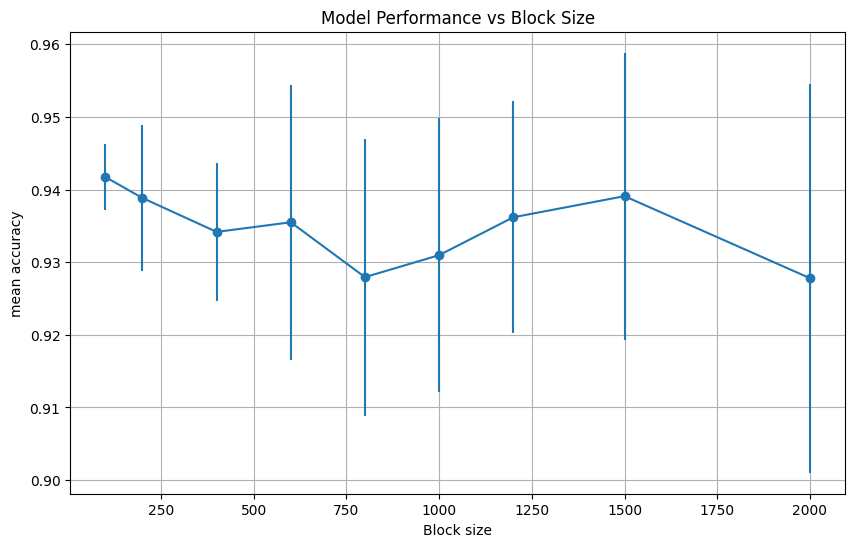

In [34]:
plt.figure(figsize=(10, 6))
plt.errorbar(block_size_results['block_size'], block_size_results['mean_accuracy'],
             yerr=block_size_results['std_accuracy'], fmt='-o')
plt.title('Model Performance vs Block Size')
plt.xlabel("Block size")
plt.ylabel("mean accuracy")
plt.grid()


# Training Data

In [50]:
# this we got from a previous preprocessing step
SHARED_FEATURES_LIST = ['MotionPlatform_FreezeAndResumeState', 'Ios_FlightAssistance_ClimbRate_Enabled', 'Ios_FlightAssistance_Pedals_Enabled', 'Aerofly_Out_Aircraft_GroundTrack', 'Aerofly_Out_Instrument_PressureAltitude', 'Aerofly_In_Aircraft_WindShearY', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo0Pressure', 'Aerofly_Out_Aircraft_AngularVelocity', 'Ios_FlightAssistance_Stable_ForwardFlight', 'Aerofly_Out_Instrument_RadarAltimeter', 'Aerofly_Out_Aircraft_AngleOfAttack', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo2Pressure', 'Aerofly_Out_Aircraft_Hydraulics_TailRotorActuatorPressure', 'Ios_FlightAssistance_Stable_Hover', 'Aerofly_Out_Aircraft_PressureAltitude', 'Aerofly_Out_Aircraft_MagneticHeading', 'Aerofly_Out_Aircraft_TrueAltitude', 'Aerofly_Out_Aircraft_Velocity', 'Aerofly_Out_Aircraft_RawAirTemperature', 'Aerofly_Out_Simulation_Fps', 'Aerofly_Running', 'Aerofly_Out_Aircraft_TrueHeading', 'Cls_MainState', 'Aerofly_Out_Aircraft_AirTemperature', 'Hardware_Controls_HelicopterThrottle', 'Aerofly_Out_Instrument_IndicatedAirspeed', 'Aerofly_In_Aircraft_WindShearX', 'Aerofly_Out_Aircraft_VerticalSpeed', 'Aerofly_Out_Aircraft_Latitude', 'Ios_LoadFactor', 'Ios_FlightAssistance_ForwardSpeed_Enabled', 'Aerofly_Out_Aircraft_Gravity', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo1Pressure', 'Ios_FlightAssistance_SideSpeed_Enabled', 'Aerofly_Out_Aircraft_Hydraulics_MainLinePressure', 'MotionPlatform_FsmState', 'Aerofly_Out_Aircraft_Pitch', 'Aerofly_Out_Aircraft_Acceleration', 'Aerofly_Out_Instrument_EngineNP', 'Aerofly_Out_Instrument_GeneratorContactorCurrent', 'Aerofly_Out_Simulation_SelectedTriangles', 'Aerofly_Out_Simulation_Time', 'Aerofly_Out_Simulation_Pause', 'Ios_Weight_Fuel', 'Aerofly_Out_Instrument_EngineNR', 'Aerofly_In_Simulation_Fade', 'Ios_GroundHeight', 'Aerofly_Out_Instrument_EngineTorqueFraction', 'Aerofly_Out_Aircraft_GroundSpeed', 'Aerofly_Out_Aircraft_TrueAirspeed', 'MotionPlatform_Running', 'Aerofly_Out_Aircraft_FuelMass', 'maneuver', 'Aerofly_Out_Aircraft_Altitude', 'CLS_U', 'Aerofly_Out_Aircraft_Bank', 'Aerofly_Out_Aircraft_RotorRotationSpeed', 'Aerofly_Out_Aircraft_SideSlip', 'Aerofly_Out_Instrument_FuelFlow', 'Ios_FlightAssistance_Throttle_Enabled', 'PoseTracking_State', 'Aerofly_Out_Aircraft_Longitude', 'Aerofly_Out_Aircraft_Height']
maneuver_map = read_maneuver_map("parsed_data/maneuver_map.json",debug=True)
    
df = training_data(SHARED_FEATURES_LIST, 800, 0.9)

Read JSON from parsed_data/maneuver_map.json: {'Hover': 0, 'Left turn': 1, 'Straight and level': 2, 'Climb': 3, 'no maneuver': 4, 'Descent': 5, 'Right turn': 6, 'Autorotation': 7}


/var/folders/5q/zzd5ty611l59s5c0_xr0tz340000gn/T/ipykernel_74688/1353790440.py:188: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labeled_index, rotation=45)


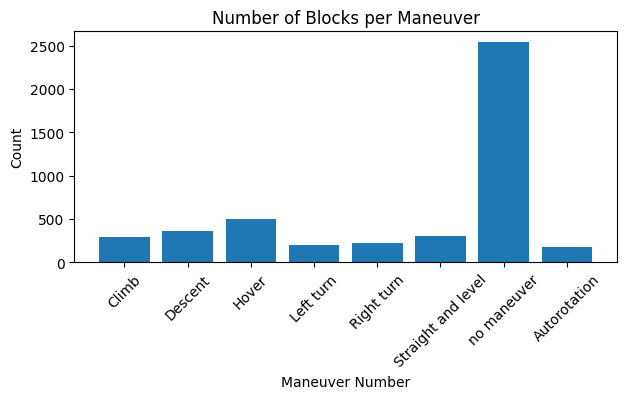

In [51]:
p = plot_maneuver_distribution(df, maneuver_map)
plt.show()

/var/folders/5q/zzd5ty611l59s5c0_xr0tz340000gn/T/ipykernel_74688/1353790440.py:188: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labeled_index, rotation=45)


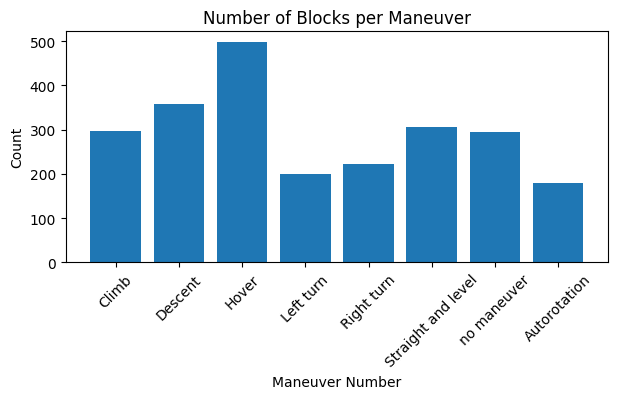

In [52]:
balanced_df = balance_maneuver_data(df)
p = plot_maneuver_distribution(balanced_df, maneuver_map)
plt.show()

# Model Evaluation Training Data (SVC and PCA)

In [ ]:
# Hyper Parameter
K_COUNT = 8

# Defining feature and target columns
X = balanced_df.drop(columns=['maneuver'])
y = balanced_df['maneuver']
# Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Apply PCA (automatically guesses how many dimensions to reduce to)
pca = PCA(n_components='mle', svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

# Check explained variance ratio
# print(f"Explained variance by components: {pca.explained_variance_ratio_}")
print("Number of dimensions before PCA: "+str(len(X.columns)))
print("Number of dimensions after PCA: "+str(pca.n_components_))

# Defining the model
model = SVC()
# Defining k-fold Cross validation
kf = KFold(n_splits=K_COUNT, shuffle=True, random_state=42)
# Train model using cross validation
cv_scores = cross_val_score(model, X_pca, y, cv=kf, scoring='accuracy')
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean accuracy: {np.mean(cv_scores):.4f}')
print(f'Standard deviation: {np.std(cv_scores):.4f}')

# Predict the labels using cross-validation
y_pred = cross_val_predict(model, X_pca, y, cv=kf)

# Calculate recall
recall = recall_score(y, y_pred, average='macro')
print(f'Recall: {recall:.4f}')

# Confusion matrix
conf_mat = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", conf_mat)

# 1. Classification Report
print("\nClassification Report:\n", classification_report(y, y_pred))

Number of dimensions before PCA: 285
Number of dimensions after PCA: 199
Cross-validation accuracy scores: [0.88813559 0.84693878 0.89795918 0.8707483  0.85034014 0.86054422
 0.89115646 0.89115646]
Mean accuracy: 0.8746
Standard deviation: 0.0189
Recall: 0.8628
Confusion Matrix:
 [[497   0   0   0   0   0   0   0]
 [  0 168  24   0   0   7   0   0]
 [  0   0 295   0   0  12   0   0]
 [  0   0  28 268   0   0   0   0]
 [ 50  14  59  32 115  18   6   0]
 [  4   0   9   0   0 344   0   0]
 [  0   0  14   0   0   0 209   0]
 [  0   0   0   0  17   1   0 162]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       497
           1       0.92      0.84      0.88       199
           2       0.69      0.96      0.80       307
           3       0.89      0.91      0.90       296
           4       0.87      0.39      0.54       294
           5       0.90      0.96      0.93       357
           6       0.97      0.94 

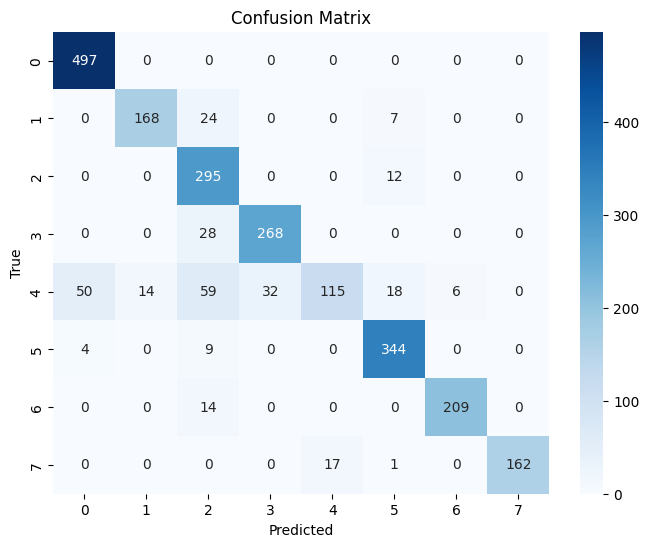

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

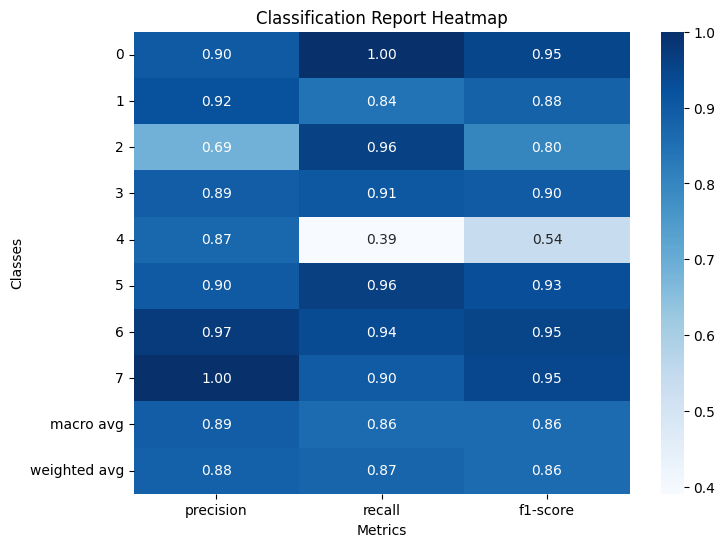

In [63]:
report = classification_report(y, y_pred, output_dict=True)

# Convert the classification report dictionary to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Drop the 'accuracy' row (since it's not relevant for a per-class view)
report_df = report_df.drop('accuracy')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:, :-1], annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

In [64]:
model.fit(X_pca, y)
# Predict the labels on the training set
train_pred_labels = model.predict(X_pca)

# Calculate recall on the training set
train_recall = recall_score(y, train_pred_labels, average='macro')
print(f'Training Recall: {train_recall:.4f}')

# Confusion matrix on the training set
train_conf_mat = confusion_matrix(y, train_pred_labels)
print("Training Confusion Matrix:\n", train_conf_mat)

# Classification Report on the training set
train_report = classification_report(y, train_pred_labels)
print("\nTraining Classification Report:\n", train_report)

Training Recall: 0.8754
Training Confusion Matrix:
 [[497   0   0   0   0   0   0   0]
 [  0 177  15   0   0   7   0   0]
 [  0   0 298   0   0   9   0   0]
 [  0   0  26 270   0   0   0   0]
 [ 48  14  64  31 118  14   5   0]
 [  3   0  13   0   0 341   0   0]
 [  0   0  12   0   0   0 211   0]
 [  0   0   0   0  12   1   0 167]]

Training Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       497
           1       0.93      0.89      0.91       199
           2       0.70      0.97      0.81       307
           3       0.90      0.91      0.90       296
           4       0.91      0.40      0.56       294
           5       0.92      0.96      0.94       357
           6       0.98      0.95      0.96       223
           7       1.00      0.93      0.96       180

    accuracy                           0.88      2353
   macro avg       0.90      0.88      0.87      2353
weighted avg       0.90      0.88    

# Model Prediction on Test Data (SVC and PCA)

In [65]:
# this we got from a previous preprocessing step
# list of shared features
SHARED_FEATURES_LIST = ['MotionPlatform_FreezeAndResumeState', 'Ios_FlightAssistance_ClimbRate_Enabled', 'Ios_FlightAssistance_Pedals_Enabled', 'Aerofly_Out_Aircraft_GroundTrack', 'Aerofly_Out_Instrument_PressureAltitude', 'Aerofly_In_Aircraft_WindShearY', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo0Pressure', 'Aerofly_Out_Aircraft_AngularVelocity', 'Ios_FlightAssistance_Stable_ForwardFlight', 'Aerofly_Out_Instrument_RadarAltimeter', 'Aerofly_Out_Aircraft_AngleOfAttack', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo2Pressure', 'Aerofly_Out_Aircraft_Hydraulics_TailRotorActuatorPressure', 'Ios_FlightAssistance_Stable_Hover', 'Aerofly_Out_Aircraft_PressureAltitude', 'Aerofly_Out_Aircraft_MagneticHeading', 'Aerofly_Out_Aircraft_TrueAltitude', 'Aerofly_Out_Aircraft_Velocity', 'Aerofly_Out_Aircraft_RawAirTemperature', 'Aerofly_Out_Simulation_Fps', 'Aerofly_Running', 'Aerofly_Out_Aircraft_TrueHeading', 'Cls_MainState', 'Aerofly_Out_Aircraft_AirTemperature', 'Hardware_Controls_HelicopterThrottle', 'Aerofly_Out_Instrument_IndicatedAirspeed', 'Aerofly_In_Aircraft_WindShearX', 'Aerofly_Out_Aircraft_VerticalSpeed', 'Aerofly_Out_Aircraft_Latitude', 'Ios_LoadFactor', 'Ios_FlightAssistance_ForwardSpeed_Enabled', 'Aerofly_Out_Aircraft_Gravity', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo1Pressure', 'Ios_FlightAssistance_SideSpeed_Enabled', 'Aerofly_Out_Aircraft_Hydraulics_MainLinePressure', 'MotionPlatform_FsmState', 'Aerofly_Out_Aircraft_Pitch', 'Aerofly_Out_Aircraft_Acceleration', 'Aerofly_Out_Instrument_EngineNP', 'Aerofly_Out_Instrument_GeneratorContactorCurrent', 'Aerofly_Out_Simulation_SelectedTriangles', 'Aerofly_Out_Simulation_Time', 'Aerofly_Out_Simulation_Pause', 'Ios_Weight_Fuel', 'Aerofly_Out_Instrument_EngineNR', 'Aerofly_In_Simulation_Fade', 'Ios_GroundHeight', 'Aerofly_Out_Instrument_EngineTorqueFraction', 'Aerofly_Out_Aircraft_GroundSpeed', 'Aerofly_Out_Aircraft_TrueAirspeed', 'MotionPlatform_Running', 'Aerofly_Out_Aircraft_FuelMass', 'maneuver', 'Aerofly_Out_Aircraft_Altitude', 'CLS_U', 'Aerofly_Out_Aircraft_Bank', 'Aerofly_Out_Aircraft_RotorRotationSpeed', 'Aerofly_Out_Aircraft_SideSlip', 'Aerofly_Out_Instrument_FuelFlow', 'Ios_FlightAssistance_Throttle_Enabled', 'PoseTracking_State', 'Aerofly_Out_Aircraft_Longitude', 'Aerofly_Out_Aircraft_Height']
maneuver_map = read_maneuver_map("parsed_data/maneuver_map.json",debug=True)
    
test_df = test_data(SHARED_FEATURES_LIST, 800, 1)


Read JSON from parsed_data/maneuver_map.json: {'Hover': 0, 'Left turn': 1, 'Straight and level': 2, 'Climb': 3, 'no maneuver': 4, 'Descent': 5, 'Right turn': 6, 'Autorotation': 7}
['parsed_test_data/f40f71de-5cc2-4719-8a5a-abcf950cbd71.pkl', 'parsed_test_data/0b3f3902-2c04-4625-8576-3bb963e3d709.pkl', 'parsed_test_data/d76bb0eb-bc08-4b35-8c1f-37369452083d.pkl', 'parsed_test_data/663f573a-74c5-4368-b60b-1fb433cd835d.pkl', 'parsed_test_data/a376807a-82d3-4526-b19f-98d4b3f9078b.pkl', 'parsed_test_data/8c36586f-94e9-4ae9-8384-0f3342008677.pkl']


/var/folders/5q/zzd5ty611l59s5c0_xr0tz340000gn/T/ipykernel_74688/1353790440.py:188: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labeled_index, rotation=45)


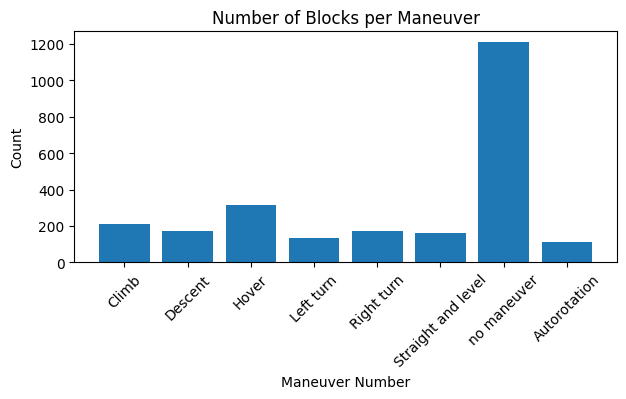

In [66]:
p = plot_maneuver_distribution(test_df, maneuver_map)
plt.show()

In [67]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2487 entries, 0 to 2486
Columns: 286 entries, Mean_MotionPlatform_FreezeAndResumeState to maneuver
dtypes: Float64(239), Int64(30), UInt8(16), category(1)
memory usage: 5.8 MB


# Model Evaluation Test Data

In [68]:
# Defining feature and target columns
test_X = test_df.drop(columns=['maneuver'])
test_y = test_df['maneuver']

test_X_scaled = scaler.transform(test_X)
test_X_pca = pca.transform(test_X_scaled)

test_pred_labels = model.predict(test_X_pca)

# Calculate recall on the training set
test_recall = recall_score(test_y, test_pred_labels, average='macro')
print('f Recall: {test_recall:.4f}')

# Confusion matrix on the training set
test_conf_mat = confusion_matrix(test_y, test_pred_labels)
print("Confusion Matrix:\n", test_conf_mat)

# Classification Report on the training set
test_report = classification_report(test_y, test_pred_labels)
print("\nClassification Report:\n", test_report)

f Recall: {test_recall:.4f}
Confusion Matrix:
 [[314   0   0   0   0   0   0   0]
 [  0 127   3   0   0   4   0   0]
 [ 20   0 136   3   0   0   0   0]
 [  0   0  20 187   1   4   0   0]
 [339  52 247 123 311  87  50   0]
 [  0   0  11   0   0 160   0   0]
 [  0   0  18   0   1   0 156   0]
 [  0   0   1   0   8   0   0 104]]

Classification Report:
               precision    recall  f1-score   support

           0       0.47      1.00      0.64       314
           1       0.71      0.95      0.81       134
           2       0.31      0.86      0.46       159
           3       0.60      0.88      0.71       212
           4       0.97      0.26      0.41      1209
           5       0.63      0.94      0.75       171
           6       0.76      0.89      0.82       175
           7       1.00      0.92      0.96       113

    accuracy                           0.60      2487
   macro avg       0.68      0.84      0.69      2487
weighted avg       0.78      0.60      0.56      24